### Libraries

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import os
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split 
from sklearn.utils import resample
from scipy import stats
import seaborn as sns
import warnings
warnings. filterwarnings('ignore')

os.chdir(r"X:\Priyabrata\NoSHOW\noshowappointments")
np.random.seed(123)

In [2]:
def knowningData(df, limit=5): #seting the function with df, 
    print(f"Dataset Shape: {df.shape}")
    print('Unique values per column: ')
    print(df.nunique())
    print("################")
    print("")    
    for column in df.columns: #initializing the loop
        print("Column Name: ", column )
        entropy = round(stats.entropy(df[column].value_counts(normalize=True), base=2),2)
        print("Entropy ", entropy, 
              " | Total nulls: ", (round(df[column].isnull().sum() / len(df[column]) * 100,2)),
              " | Total unique values: ", df.nunique()[column], #print the data and % of nulls
              " | Missing: ", df[column].isna().sum())
        print("Top 5 most frequent values: ")
        print(round(df[column].value_counts(normalize=True)[:5],2))
        print("")
        print("####################################")

def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, 
                                    prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
        
    return df

# This function is to extract date features
def date_process(df, cols, form=None):
    for col in cols:

        df[col] = pd.to_datetime(df[col]) # seting the column as pandas datetime
        df['_weekdayName_'+str(col)] = df[col].dt.weekday_name #extracting week day
        df['_weekday_'+str(col)] = df[col].dt.weekday #extracting week day        
        df['_day_'+str(col)] = df[col].dt.day # extracting day
        df['_month_'+str(col)] = df[col].dt.month # extracting month
        if col == 'ScheduledDay':
            df['_hour_'+str(col)] = df[col].dt.hour # extracting hour
            df['_minute_'+str(col)] = df[col].dt.minute # extracting minute
        # df[col] = df[col].dt.date.astype('datetime64[ns]')
        
    return df #returning the df after the transformations

In [3]:
noshow = pd.read_csv('KaggleV2-May-2016.csv')

In [4]:
noshow.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Analyzing data

In [5]:
knowningData(noshow.drop(['PatientId', 'AppointmentID'], axis=1))

Dataset Shape: (110527, 12)
Unique values per column: 
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64
################

Column Name:  Gender
Entropy  0.93  | Total nulls:  0.0  | Total unique values:  2  | Missing:  0
Top 5 most frequent values: 
F    0.65
M    0.35
Name: Gender, dtype: float64

####################################
Column Name:  ScheduledDay
Entropy  16.61  | Total nulls:  0.0  | Total unique values:  103549  | Missing:  0
Top 5 most frequent values: 
2016-05-06T07:09:54Z    0.0
2016-05-06T07:09:53Z    0.0
2016-04-25T17:18:27Z    0.0
2016-04-25T17:17:46Z    0.0
2016-04-25T17:17:23Z    0.0
Name: ScheduledDay, dtype: float64

####################################
Column Name:  AppointmentDay
Entropy  4.7  | Tot

In [6]:
#Features and data types
binary_features = ['Scholarship', 'Hipertension', 'Diabetes',
                   'Alcoholism', 'SMS_received', 'Gender']
target = ['No-show']
categorical = ['Neighbourhood', 'Handcap']
numerical = ['Age']
dates = ['AppointmentDay', 'ScheduledDay']
Ids = ['PatientId', 'AppointmentID']

In [7]:
## Transforming dates to datetime
noshow_clean= date_process(noshow, dates)

print(f"Total of Unique Patients is {noshow_clean.PatientId.nunique()} and Appointments is {noshow_clean.AppointmentID.nunique()}")

noshow_clean_age = noshow_clean[(noshow_clean.Age >= 0 ) & (noshow_clean.Age <= 100)]
print(f"Shape after filtering Data: {noshow_clean_age.shape}")

Total of Unique Patients is 62299 and Appointments is 110527
Shape after filtering Data: (110519, 24)


**Age**

In [8]:
#Creating Age bins and categories
bin_ranges = [-1, 2, 8, 16, 18, 25, 40, 50, 60, 75]
bin_names = ["Baby", "Children", "Teenager", 'Young', 'Young-Adult', 'Adult', 'Adult-II', 'Senior', 'Old']

noshow_clean_age['age_bin'] = pd.cut(np.array(noshow_clean_age['Age']),
                               bins=bin_ranges, labels=bin_names)

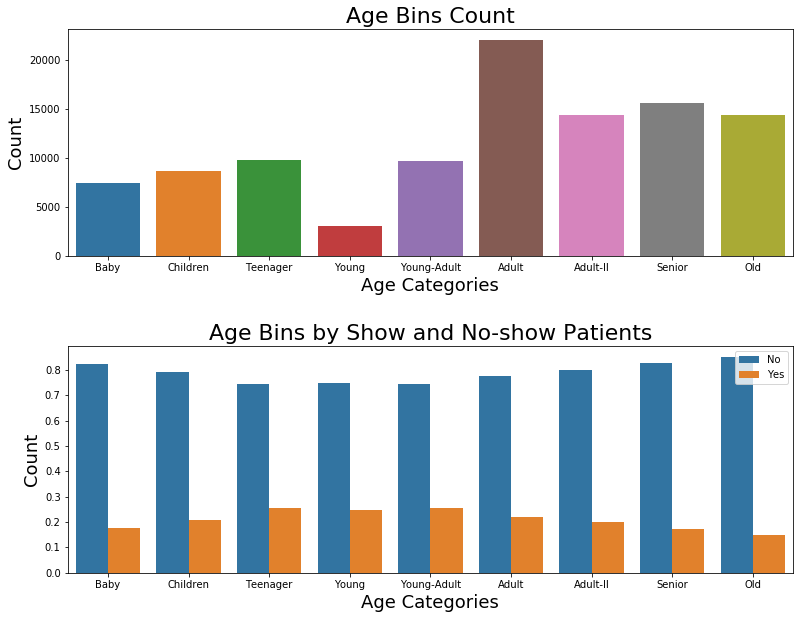

In [10]:
# now stack and reset
show_prob_age = pd.crosstab(noshow_clean_age['age_bin'], noshow_clean_age['No-show'], normalize='index')
stacked = show_prob_age.unstack().reset_index().rename(columns={0:'value'})

plt.figure(figsize=(13,10))
plt.subplot(211)
ax1 = sns.countplot(x="age_bin", data=noshow_clean_age)
ax1.set_title("Age Bins Count", fontsize=22)
ax1.set_xlabel("Age Categories", fontsize=18)
ax1.set_ylabel("Count", fontsize=18)

plt.subplot(212)
ax2 = sns.barplot(x=stacked.age_bin, y=stacked.value, hue=stacked['No-show'])
ax2.set_title("Age Bins by Show and No-show Patients", fontsize=22)
ax2.set_xlabel("Age Categories", fontsize=18)
ax2.set_ylabel("Count", fontsize=18)
ax2.legend(loc='out')

plt.subplots_adjust(hspace = 0.4)
plt.show()

**Binary Features**

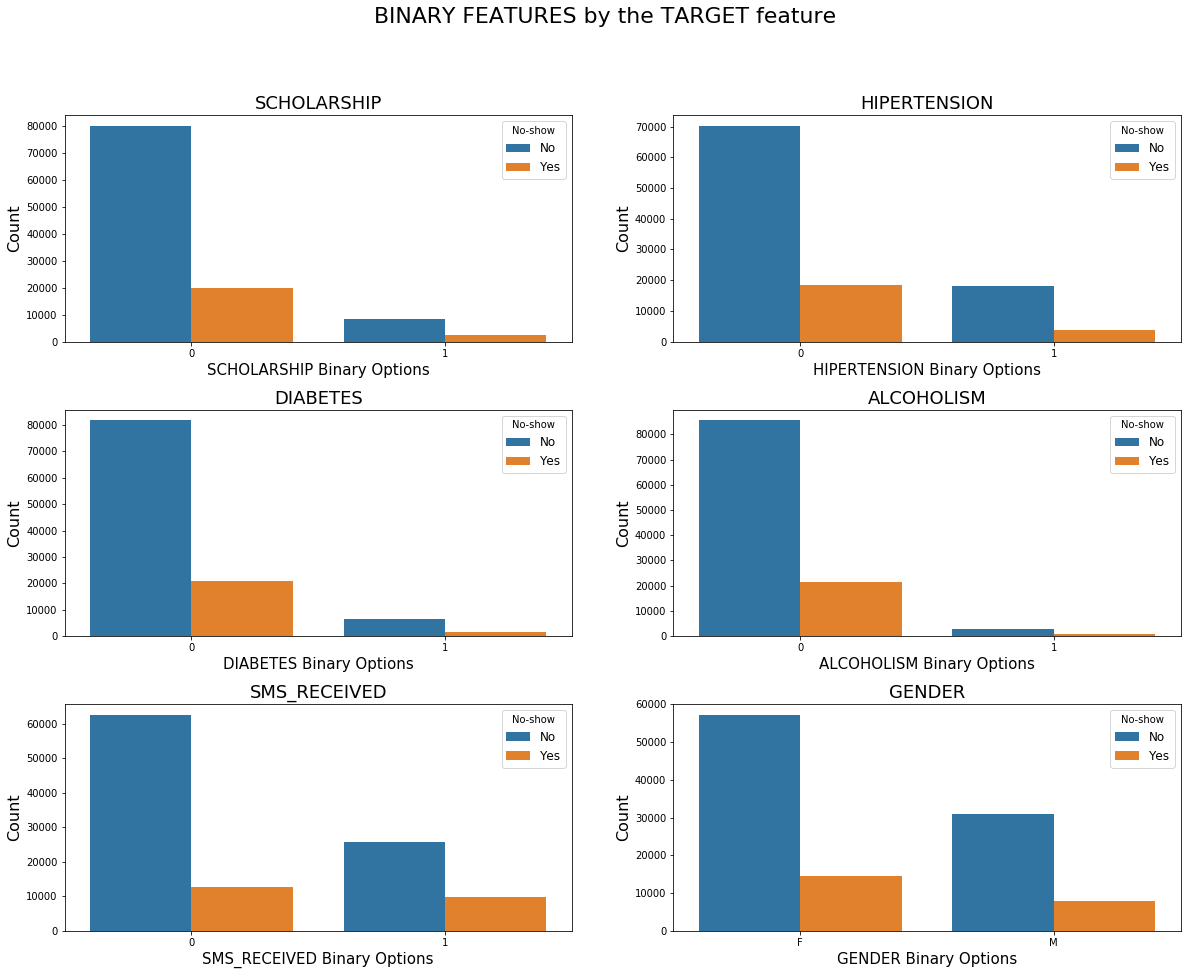

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('BINARY FEATURES by the TARGET feature', fontsize=22)

for ax, catplot in zip(axes.flatten(), noshow_clean_age[binary_features].columns):
    sns.countplot(x=catplot, data=noshow_clean_age, hue='No-show', ax=ax)
    ax.set_title(catplot.upper(), fontsize=18)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_xlabel(f'{catplot.upper()} Binary Options', fontsize=15)
    ax.legend(title='No-show', fontsize=12, )

**SMS received**

In [13]:
sms_received = noshow_clean_age.groupby([noshow_clean_age['AppointmentDay'].dt.date,
                                 "SMS_received", "No-show"])['PatientId'].count().reset_index().rename(columns={'PatientId': "Total"})

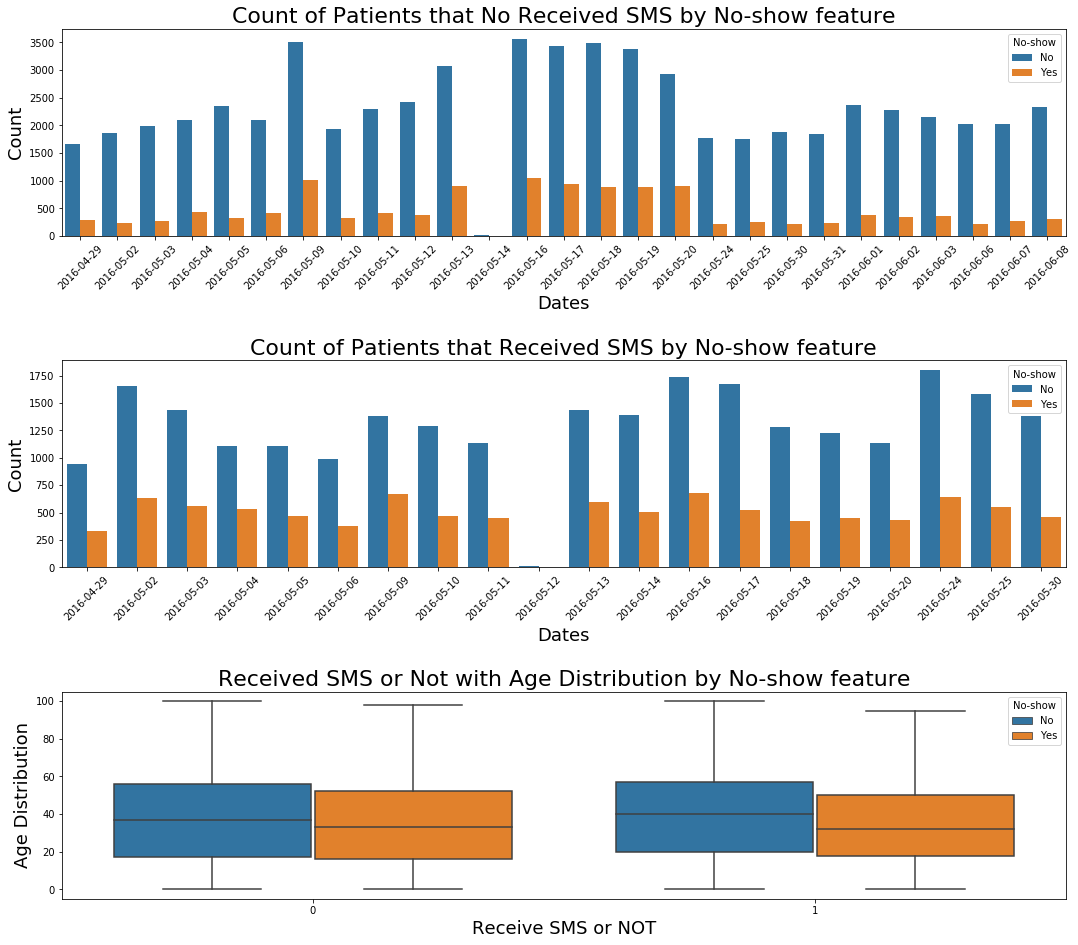

In [15]:
plt.figure(figsize=(18,16))

plt.subplot(3,1,1)
g = sns.barplot(x='AppointmentDay', y= 'Total', hue='No-show', data=sms_received[sms_received['SMS_received'] == 0])
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Count of Patients that No Received SMS by No-show feature", fontsize=22)
g.set_xlabel("Dates", fontsize=18)
g.set_ylabel("Count", fontsize=18)

plt.subplot(3,1,2)
g1 = sns.barplot(x='AppointmentDay', y= 'Total', hue='No-show', data=sms_received[sms_received['SMS_received'] == 1])
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Count of Patients that Received SMS by No-show feature", fontsize=22)
g1.set_xlabel("Dates", fontsize=18)
g1.set_ylabel("Count", fontsize=18)

plt.subplot(3,1,3)
g2 = sns.boxplot(x='SMS_received', y= 'Age', hue='No-show', data=noshow_clean_age)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_title("Received SMS or Not with Age Distribution by No-show feature", fontsize=22)
g2.set_xlabel("Receive SMS or NOT", fontsize=18)
g2.set_ylabel("Age Distribution", fontsize=18)

plt.subplots_adjust(hspace = 0.6)
plt.show()

**Waiting Days**

In [16]:
## Creating a feature that is the difference between the schedule and the appointment 
noshow_clean_age['waiting_days'] = (noshow_clean_age['AppointmentDay'] - noshow_clean_age['ScheduledDay']).dt.days
noshow_clean_age = noshow_clean_age[(noshow_clean_age['waiting_days'] >= -1) & (noshow_clean_age['waiting_days'] <=100)]
noshow_clean_age.Gender = noshow_clean_age['Gender'].map({"F":0, "M":1})
noshow_clean_age['No-show'] = noshow_clean_age['No-show'].map({"No":0, "Yes":1})
noshow_clean_age = dummies(noshow_clean_age, categorical)
noshow_clean_age.drop(['_weekdayName_AppointmentDay', 'AppointmentID', 'PatientId', 'age_bin',
                         'ScheduledDay', 'AppointmentDay', '_weekdayName_AppointmentDay',
                         '_weekdayName_ScheduledDay'], axis=1, inplace=True)
noshow_clean_age.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,_weekday_AppointmentDay,_day_AppointmentDay,...,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,Handcap_1,Handcap_2,Handcap_3,Handcap_4
0,0,62,0,1,0,0,0,0,4,29,...,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,4,29,...,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,4,29,...,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,4,29,...,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,4,29,...,0,0,0,0,0,0,0,0,0,0


**TRAIN & TEST DATASET**

In [24]:
#CREATING X & Y
#noshow_clean_age.rename(columns={'No-show':'noshow'},inplace=True)
X = noshow_clean_age.drop(['noshow'],axis=1)
y = noshow_clean_age['noshow']

#cont_features = ['Noshow24NBR', 'CancellationsNBR', 'Rescheduled24NBR', 'Confirmed24NBR','cnt_prov', 'that_provider_cnt', 'noshow_rate', 'age',
       #'duration', 'daysfuture', 'cancelled_rate', 'rescheduled_rate',
       #'avg_checkintoappt', 'num_officevisits_NBR', 'num_drugs', 'num_prescriptions']

#STANDARDIZED THE RECORDS
#normalized_df=(X[cont_features]-X[cont_features].mean())/X[cont_features].std()
#col_obj_list = X.columns[X.columns.isin(cont_features) == False]
#X = pd.merge(normalized_df, X[col_obj_list], left_index = True, right_index = True)
#SPLITTING INTO TRAIN & TEST
X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size=0.3, random_state=73)
print('Training shape' , X_train.shape)
print('Test shape', X_test.shape)

Training shape (77263, 100)
Test shape (33114, 100)


**RESAMPLING**

In [25]:
# separate minority and majority classes
# concatenate our training data back together
XT = pd.concat([X_train, Y_train], axis=1)
show = XT[XT.noshow==0]
noshow_r = XT[XT.noshow==1]

# upsample minority
noshow_upsampled = resample(noshow_r,
                          replace=True, # sample with replacement
                          n_samples=len(show), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
XT_r = pd.concat([show, noshow_upsampled])

print(XT_r.noshow.value_counts())

1    61653
0    61653
Name: noshow, dtype: int64


In [26]:
XT_r.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_weekday_AppointmentDay,_day_AppointmentDay,_month_AppointmentDay,...,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,Handcap_1,Handcap_2,Handcap_3,Handcap_4,noshow
88155,1,27,0,0,1,0,0,1,7,6,...,0,0,0,0,0,0,0,0,0,0
89615,1,2,0,0,0,0,1,2,1,6,...,0,0,0,0,0,0,0,0,0,0
78780,0,61,0,0,0,0,0,0,2,5,...,0,0,0,0,0,0,0,0,0,0
32436,0,17,0,0,0,0,0,4,13,5,...,0,0,0,0,0,0,0,0,0,0
46355,1,33,0,0,0,0,0,2,11,5,...,0,0,0,0,0,0,0,0,0,0


**RESHAPING DATASET**

In [27]:
features = XT_r.drop(columns='noshow').values.T
label = XT_r['noshow'].values.reshape(-1,1).T
test_features = X_test.values.T
test_label = Y_test.values.reshape(-1,1).T
print(features)
print(label)
print(features.shape)
print(label.shape)

[[ 1  1  0 ...  1  0  1]
 [27  2 61 ...  5 27 19]
 [ 0  0  0 ...  0  0  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[0 0 0 ... 1 1 1]]
(100, 123306)
(1, 123306)


**DEFINING LAYER SIZES**

In [28]:
def layer_sizes (X,Y,hidden_units):
    
    n_input = X.shape[0]
    n_output = Y.shape[0]
    n_hidden = hidden_units
    
    return (n_input, n_output, n_hidden)

**WEIGHT & BIAS INITIALIZATION**

In [29]:
def weight_bias (n_input,n_output, n_hidden):
    np.random.seed(2)
    w1 = np.random.randn(n_hidden,n_input)*0.01
    b1 = np.zeros(shape=(n_hidden,1))
    w2 = np.random.randn(n_output,n_hidden)*0.01
    b2 = np.zeros(shape=(n_output,1))
    
    parameters = {'w1':w1,
                  'b1':b1,
                  'w2':w2,
                  'b2':b2}
    return parameters    

**SIGMOID ACTIVATION**

In [30]:
def sigmoid(z):
    new_value = 1/(1+(np.exp(-z)))
    return new_value

**FORWARD PROPAGTION**

In [31]:
def forward_prop(features,parameters) :
    
    w1 = parameters['w1']
    w2 = parameters['w2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    z1 = np.dot(w1,features) + b1
    a1 = np.tanh(z1)
    
    z2 = np.dot(w2,a1) + b2
    a2 = sigmoid(z2)
    
    cache = {'z1':z1,
             'a1':a1,
             'z2':z2,
             'a2':a2}
  
    return a2,cache

**COST FUNCTION**

In [32]:
def cost(a2,label):
    m = label.shape[1]
    
    logprobs = np.multiply(np.log(a2), label) + np.multiply((1-label),np.log(1-a2))
    cost = -np.sum(logprobs) / m
    cost_value = float(np.squeeze(cost))
    
    return cost_value
    

**BACK PROPAGATION**

In [33]:

def back_propagation(parameters,cache, features, label) :
    m = features.shape[1]
    a1 = cache['a1']
    a2 = cache['a2']
    z1 = cache['z1']
    z2 = cache['z2']
    
    w1 = parameters['w1']
    w2 = parameters['w2']
    
    dz2 = a2 - label
    dw2 = (1/m)*np.dot(dz2,a1.T) 
    db2 = (1/m)*np.sum(dz2,axis=1,keepdims = True)
    dz1 = np.multiply(np.dot(w2.T,dz2),1 - np.power(a1, 2))
    dw1 = (1 / m) * np.dot(dz1, features.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
   
    grads = {"dw1": dw1,
             "db1": db1,
             "dw2": dw2,
             "db2": db2}
    
    return grads  

**WEIGHT & BIAS UPDATE**

In [34]:
def update_parameters(parameters,grads,learning_rate=1.2):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    dw1 = grads['dw1']
    dw2 = grads['dw2']
    db1 = grads['db1']
    db2 = grads['db2']
    
    w1 = w1 - learning_rate*dw1
    w2 = w2 - learning_rate*dw2
    b1 = b1 - learning_rate*db1
    b2 = b2 - learning_rate*db2
    
    parameters = {'w1':w1,
                  'b1':b1,
                  'w2':w2,
                  'b2':b2}
    return parameters    

**COMPLETE MODEL**

In [35]:
def dnn_model(features, label,n_hidden,iterations,print_cost=False):
    n_input,n_output,n_hidden = layer_sizes(features,label,n_hidden)
    parameters = weight_bias(n_input,n_output,n_hidden)
    cost_value = 0
    
    for i in range(0, iterations):
        a2,cache = forward_prop(features,parameters)
        cost_value = cost(a2,label)
        grads = back_propagation(parameters,cache,features,label)
        parameters = update_parameters(parameters,grads,learning_rate=0.05)
        
        if print_cost and i % 1 ==0:
            print('Iteration:', i,' ', 'cost ',cost_value)
            
    return parameters


In [36]:
parameters = dnn_model(features, label, 128, 20,True)

Iteration: 0   cost  0.6935669428935809
Iteration: 1   cost  0.6894353622120346
Iteration: 2   cost  0.6865235056310921
Iteration: 3   cost  0.6839277218440888
Iteration: 4   cost  0.6814845689344796
Iteration: 5   cost  0.6791520100977954
Iteration: 6   cost  0.6769178764559615
Iteration: 7   cost  0.6747831106418082
Iteration: 8   cost  0.6727559216903677
Iteration: 9   cost  0.6708477570189144
Iteration: 10   cost  0.6690698091737497
Iteration: 11   cost  0.6674301495289198
Iteration: 12   cost  0.6659319950498104
Iteration: 13   cost  0.6645734368791363
Iteration: 14   cost  0.6633483445994617
Iteration: 15   cost  0.662247744729836
Iteration: 16   cost  0.6612610944764222
Iteration: 17   cost  0.6603772272719207
Iteration: 18   cost  0.6595849840785694
Iteration: 19   cost  0.6588736140273683


**PREDICTIONS**

In [37]:
def Prediction(parameters,features):
    a2, cache = forward_prop(test_features,parameters)
    predictions = np.round(a2)
    
    return predictions

**ACCURACY**

In [38]:
predictions = Prediction(parameters,test_features)
print ('Accuracy: %d' % float((np.dot(test_label,predictions.T) + np.dot(1-test_label,1-predictions.T))/float(test_label.size)*100) + '%')

Accuracy: 66%


**SENSITIVITY**

In [39]:
TP = np.squeeze(np.dot(test_label,predictions.T))
TN = np.squeeze(np.dot(1-test_label,1-predictions.T))
FN = np.squeeze(test_label[np.where(test_label == 0)].shape[0]  -   np.dot(1-test_label,1-predictions.T))
sensitivity = np.round((TP*100/(TP+FN)),2)
sensitivity

31.46

**PRECISION**

In [41]:
FP = np.squeeze(predictions[np.where(predictions == 1)].shape[0])  -   TP
print((TP*100)/(TP+FP))

31.457092525794817
